In [1]:
# import libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report
import seaborn as sns


# Analysing the 'Hausfrauenhoch'

![AI Rendering of a cliché housewife trading](image.png "Image generated with https://huggingface.co/spaces/black-forest-labs/FLUX.1-dev")

Explanation from ChatGPT:

> The German term **"Hausfrauenhoch"** refers to a phenomenon in the stock market where even inexperienced investors (often retail or small-scale private investors) start investing during a market phase characterized by significant price increases. This behavior typically occurs in the later stages of a bull market, just before a market correction or crash. The term alludes to the idea that even less knowledgeable investors (such as housewives, according to the cliché) begin to invest in the stock market because they believe that profits are "guaranteed."
> 
> There isn't a direct equivalent term in English, but there are similar terms and phrases that can describe the concept. Examples include:
> 
> 1. **Late-stage bull market rally**  
>    Refers to the late phase of a bull market, where prices often continue to rise without fundamental justification, driven by optimism and speculation.
> 
> 2. **Retail investor frenzy**  
>    Describes the behavior of retail investors entering the market in large numbers, often without deep knowledge or expertise.
> 
> 3. **Market euphoria** or **irrational exuberance**  
>    These terms describe the over-the-top enthusiasm and often irrational overvaluation of markets.
> 
> 4. **FOMO buying** (Fear of Missing Out)  
>    Refers to the phenomenon where investors buy into the market out of fear of missing the rally, which further drives prices higher.
> 
> While none of these terms captures the exact nuance of *"Hausfrauenhoch,"* they can be used to describe the broader phenomenon in English.


## Accessing the python code

This notebook is rendered in two versions:

* just the explanations and results visible at [https://michael-zeller.github.io/udacity_cd1971/]
* the complete notebook with the code visible at [https://michael-zeller.github.io/udacity_cd1971/fomo_btc.html]

## Used data

As an indicator for the overall interest in bitcoin and crypto investment we use data from google trends. You can access this data under [Google Trends for bitcoin,investment,inflation,economy,crypto](https://trends.google.de/trends/explore?date=2020-01-01%202025-01-01&q=bitcoin,investment,inflation,economy,crypto&hl=de).

Bitcoin relevant information is retrieved from (Bitcoinity Price and Volume)(https://data.bitcoinity.org/markets/price_volume/5y/USD?r=week&t=lb&vu=curr)

Both datasets have a horizon from 5 years and a weekly resolution.

In [2]:
# load data

price_vol_usd_btc = pd.read_csv('data/bitcoinity_price_volume_USD_btc_5y.csv')    # Preis und Volumen in USD
google_trends = pd.read_csv('data/googleTrends_5y.csv')

# convert date to datetime
google_trends['date'] = pd.to_datetime(google_trends['Woche'])
price_vol_usd_btc['date'] = pd.to_datetime(price_vol_usd_btc['Time'])

# add a new column with year and week
google_trends['year_week'] = google_trends['date'].dt.strftime('%Y-%U')
price_vol_usd_btc['year_week'] = price_vol_usd_btc['date'].dt.strftime('%Y-%U')

# merge data by year and week
weekly_data = pd.merge(google_trends, price_vol_usd_btc, on='year_week')

weekly_data.drop(columns=['Woche', 'date_x', 'date_y', 'Time'], inplace=True)
weekly_data.rename(columns={'volume': 'volume_usd'}, inplace=True)

weekly_data.set_index('year_week', inplace=True)

## First look at the data

We normalize the values for the interest in 'bitcoin' the price and trading volume in USD and render it as a line chart.

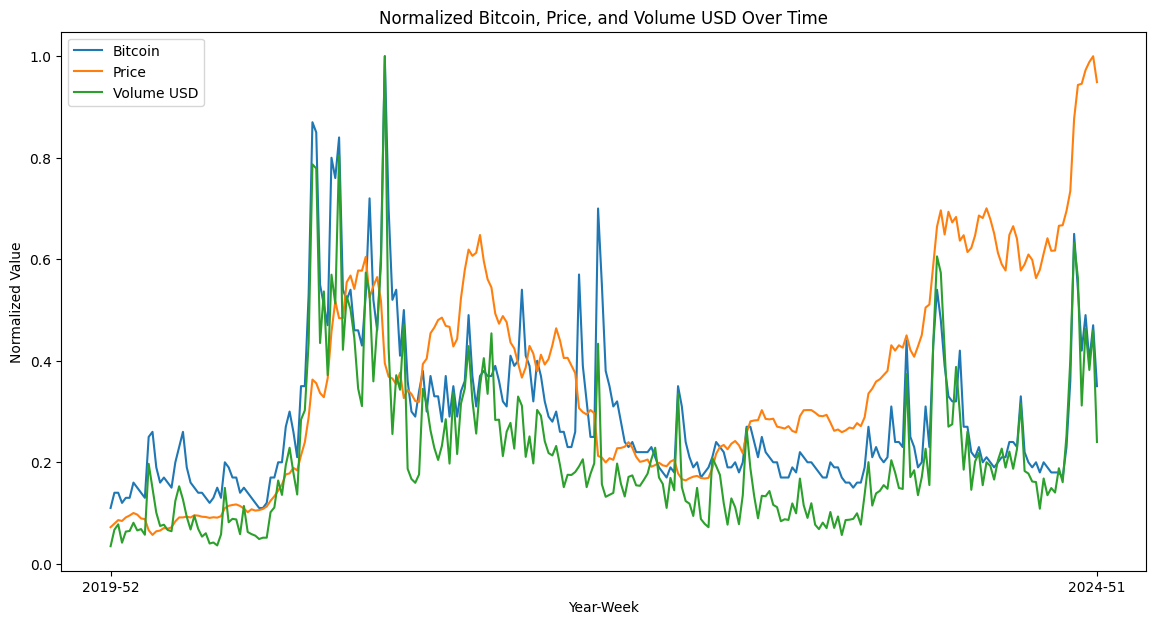

In [3]:

# Normalize each column to its highest point
normalized_data = weekly_data[['bitcoin', 'price', 'volume_usd']].apply(lambda x: x / x.max())

# Plot the normalized data
plt.figure(figsize=(14, 7))
plt.plot(normalized_data.index, normalized_data['bitcoin'], label='Bitcoin')
plt.plot(normalized_data.index, normalized_data['price'], label='Price')
plt.plot(normalized_data.index, normalized_data['volume_usd'], label='Volume USD')

plt.xlabel('Year-Week')
plt.ylabel('Normalized Value')
plt.title('Normalized Bitcoin, Price, and Volume USD Over Time')
plt.legend()
plt.xticks([normalized_data.index[0], normalized_data.index[-1]], [normalized_data.index[0], normalized_data.index[-1]])
plt.grid(False)
plt.show()

A first glance shows, that their might be a correlation between the interest for bitcoin and the trading volume.

Next, we calculate the price difference in percent from one week to the next (bars in blue (positive diff)  and red(negativ diff)) und show the trading volume on top.

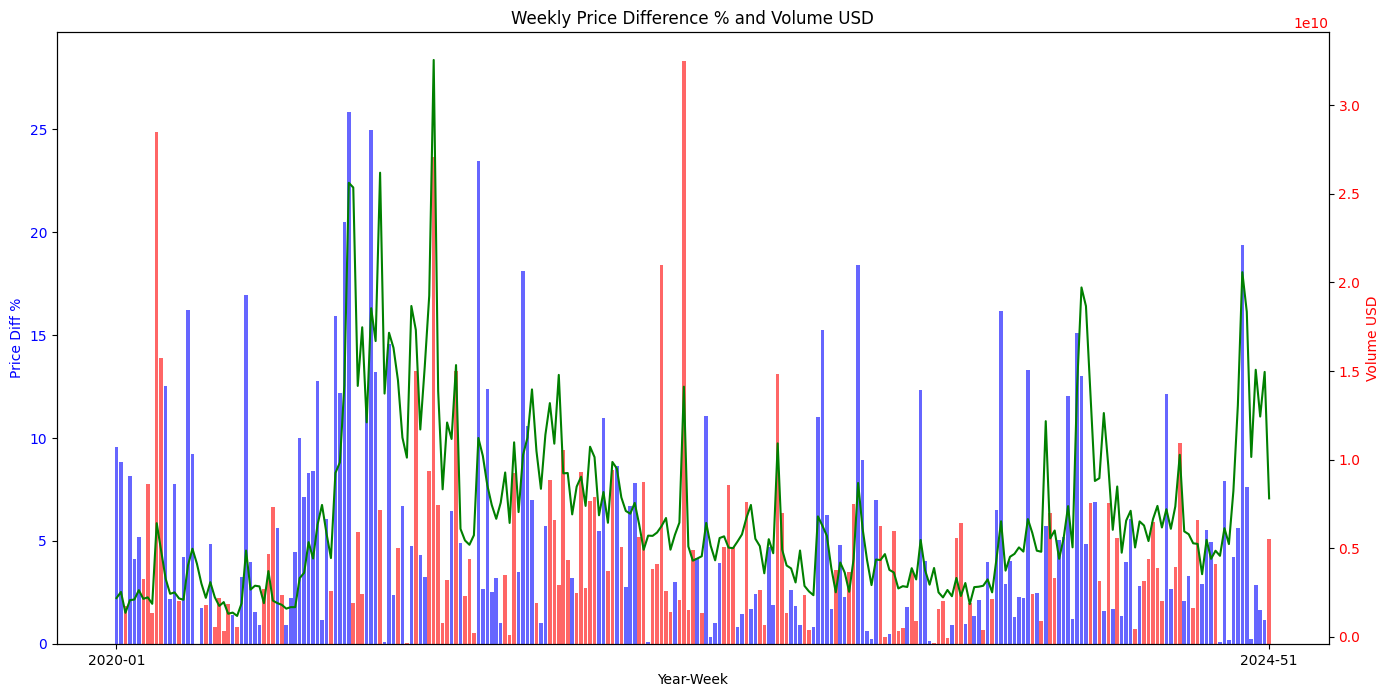

In [4]:
# Calculate the price difference in percent to the previous week
weekly_data['price_diff_pct'] = weekly_data['price'].pct_change() * 100

# Drop the first row as it will have NaN value for price_diff_pct
weekly_data.dropna(subset=['price_diff_pct'], inplace=True)

# Plot the price difference as a bar chart and the volume as a line chart
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar chart for price difference with absolute values
colors = ['b' if val >= 0 else 'r' for val in weekly_data['price_diff_pct']]
ax1.bar(weekly_data.index, weekly_data['price_diff_pct'].abs(), color=colors, alpha=0.6, label='Price Diff %')
ax1.set_xlabel('Year-Week')
ax1.set_ylabel('Price Diff %', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Line chart for volume
ax2 = ax1.twinx()
ax2.plot(weekly_data.index, weekly_data['volume_usd'], color='g', label='Volume USD')
ax2.set_ylabel('Volume USD', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.xticks([weekly_data.index[0], weekly_data.index[-1]], [weekly_data.index[0], weekly_data.index[-1]])
plt.grid(False)
plt.title('Weekly Price Difference % and Volume USD')
plt.show()

# drop the created column
weekly_data.drop(columns=['price_diff_pct'], inplace=True)

As might be expected, high price changes correspond roughly with high trading volume.

## data preparation for machine learning

After merging the data by the calender week, we have a dataset with the following columns:

In [5]:
# show columns of weekly_data
print(', '.join(weekly_data.columns))

bitcoin, investment, inflation, economy, crypto, price, volume_usd


As we want to predict the price-value of next week **price+1w** using the other provided data from this week and historical data, we create the according colums. We have to remove the first few rows, as we don't have historical data for them and the last row (no prediction value available).

In [6]:
# build up the final data structure

# create columns for historical data
for col in weekly_data.columns:
    if col != 'price':
        weekly_data[f'{col}-1w'] = weekly_data[col].shift(1)
        weekly_data[f'{col}-2w'] = weekly_data[col].shift(2)
        weekly_data[f'{col}-5w'] = weekly_data[col].shift(5)

# create column for target (price in 1 week)
weekly_data['price+1w'] = weekly_data['price'].shift(-1)

# drop rows with NaN (no history for first 5 weeks)
weekly_data = weekly_data.iloc[5:]

# drop last row (no target for last week)
weekly_data = weekly_data.iloc[:-1]

# defragmented copy of the data
weekly_data = weekly_data.copy()

In [7]:
# show columns of weekly_data
print(', '.join(weekly_data.columns))

bitcoin, investment, inflation, economy, crypto, price, volume_usd, bitcoin-1w, bitcoin-2w, bitcoin-5w, investment-1w, investment-2w, investment-5w, inflation-1w, inflation-2w, inflation-5w, economy-1w, economy-2w, economy-5w, crypto-1w, crypto-2w, crypto-5w, volume_usd-1w, volume_usd-2w, volume_usd-5w, price+1w


In [8]:


# Split the data into features and target
X = weekly_data.drop(columns=['price+1w'])
y = weekly_data['price+1w']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 17306955.838115636
R^2 Score: 0.96641846415169


The mean squared Error doesn't mean a lot, because the value of bitcoin changed a lot over the last years. But the R^2-Score sounds promissing.

## using the model for investment

If we use our model to predict the price in one week, we can invest our hard earned money. What would be the outcome?

For this to test, we merge our test-dataframes back together.

In [16]:
# combine X_test and y_test and y_pred
test_results = X_test.copy()
test_results = test_results[['price']]
test_results['price+1w'] = y_test
test_results['price+1w_pred'] = y_pred

# order the rows by year_week
test_results.sort_index(inplace=True)

# create a column that shows the percentage difference between the current week price and the price+1w
test_results['price+1w_diff_pct'] = (test_results['price+1w'] - test_results['price']) / test_results['price'] * 100

# create a column that shows, if the predicted price is higher or lower than the price of the current week
test_results['price+1w_pred_diff'] = test_results['price+1w_pred'] - test_results['price']
test_results['price+1w_pred_diff'] = test_results['price+1w_pred_diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

# create a column that shows, if the actual price+1w is higher or lower than the price of the current week
test_results['price+1w_diff'] = test_results['price+1w'] - test_results['price']
test_results['price+1w_diff'] = test_results['price+1w_diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

# create a column that shows, if the prediction is correct
test_results['correct'] = test_results['price+1w_diff'] == test_results['price+1w_pred_diff']



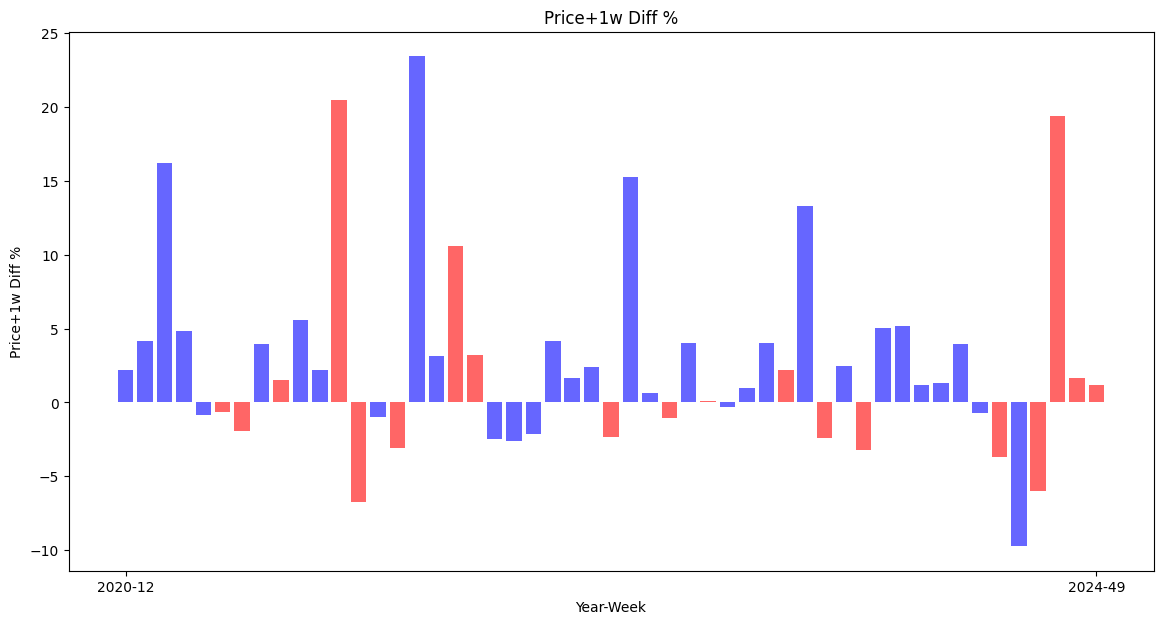

In [17]:
# render a bar chart of the price+1w_diff_pct. The color should be red, if the prediction was wrong, and blue if it was correct
fig, ax = plt.subplots(figsize=(14, 7))
colors = ['r' if val == False else 'b' for val in test_results['correct']]
ax.bar(test_results.index, test_results['price+1w_diff_pct'], color=colors, alpha=0.6)
ax.set_xlabel('Year-Week')
ax.set_ylabel('Price+1w Diff %')
plt.xticks([test_results.index[0], test_results.index[-1]], [test_results.index[0], test_results.index[-1]])
plt.grid(False)
plt.title('Price+1w Diff %')
plt.show()


The bars show the actual percentage differenc of price and price+1w (real prices). If the bar is blue, we predicted the right direction of the price. If the bar is red, the prediction was fundamentaly wrong. We miss-predicted some big price differences, but overall this seems ok. 

So let's see, what happens if we invest some money. If we predict rising prices, we buy Bitcoin. If we predict falling prices, we short Bitcoin and profit from the falling prices. But only, if we are right :). 

In this way we can compute our investment simply by multiplying with the actual price difference (size of the bars) and than adding or subtracting depending if we were right or wrong. If we consistently invest 100$ each week, we can just add the absolut values of all blue-bar-percentages and subtract the red ones.

In [18]:
# add the absolute value of the price+1w_diff_pct to the test_results dataframe
test_results['price+1w_diff_pct_abs'] = test_results['price+1w_diff_pct'].abs()

# multiply by -1 if the prediction was wrong
test_results['price+1w_diff_result'] = test_results.apply(lambda x: x['price+1w_diff_pct_abs'] * -1 if x['correct'] == False else x['price+1w_diff_pct_abs'], axis=1)

# compute the sum of the price+1w_diff_result column
sum_diff = test_results['price+1w_diff_result'].sum()



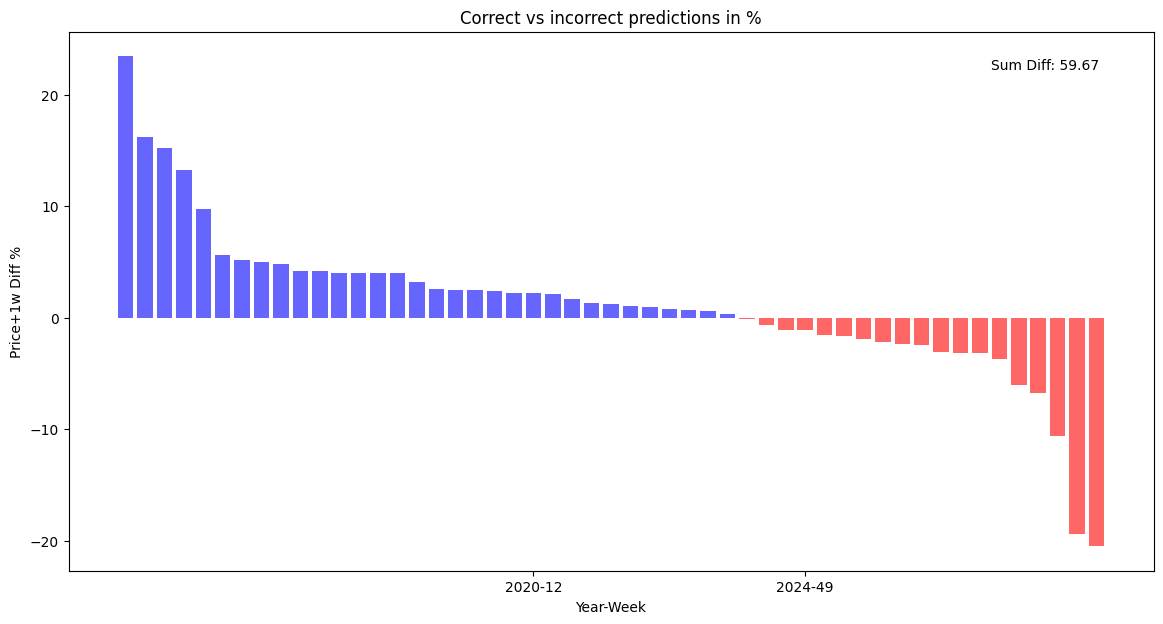

In [22]:
# render a bar chart of the price+1w_diff_result. The color should be red, if the prediction was wrong, and blue if it was correct. order by size
fig, ax = plt.subplots(figsize=(14, 7))
test_results_sorted = test_results.sort_values('price+1w_diff_result', ascending=False)
colors = ['r' if val == False else 'b' for val in test_results_sorted['correct']]
ax.bar(test_results_sorted.index, test_results_sorted['price+1w_diff_result'], color=colors, alpha=0.6)
ax.set_xlabel('Year-Week')
ax.set_ylabel('Price+1w Diff %')
plt.xticks([test_results.index[0], test_results.index[-1]], [test_results.index[0], test_results.index[-1]])
plt.grid(False)
plt.title('Correct vs incorrect predictions in %')

# Add sum_diff to the top right corner
plt.text(0.95, 0.95, f'Sum Diff: {sum_diff:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

plt.show()


## scratch pad for unfinished ideas...

In [4]:


with open('data/blockchain_tx-per-day_tx-vol.json', 'r') as f:
    tx_vol = json.load(f)

with open('data/blockchain_tx-per_day_tx-vol-usd.json', 'r') as f:
    tx_usd = json.load(f)

with open('data/blockchain_trade-volume_market-price.json', 'r') as f:
    vol_price = json.load(f)

   

In [9]:
# estimated-transaction-volume per day in btc
df_tx_vol = pd.DataFrame(tx_vol['estimated-transaction-volume'])
df_tx_vol['time'] = pd.to_datetime(df_tx_vol['x'], unit='ms')
df_tx_vol.set_index('time', inplace=True)
df_tx_vol.drop(columns='x', inplace=True)
df_tx_vol.rename(columns={'y': 'estimated_tx_vol_usd'}, inplace=True)


# number of transactions per day
df_n_tx = pd.DataFrame(tx_vol['n-transactions'])
df_n_tx['time'] = pd.to_datetime(df_n_tx['x'], unit='ms')
df_n_tx.set_index('time', inplace=True)
df_n_tx.drop(columns='x', inplace=True)
df_n_tx.rename(columns={'y': 'n-transactions'}, inplace=True)

# estimated-transaction-volume per day in usd
df_tx_vol_usd = pd.DataFrame(tx_usd['estimated-transaction-volume-usd'])
df_tx_vol_usd['time'] = pd.to_datetime(df_tx_vol_usd['x'], unit='ms')
df_tx_vol_usd.set_index('time', inplace=True)
df_tx_vol_usd.drop(columns='x', inplace=True)
df_tx_vol_usd.rename(columns={'y': 'estimated-transaction-volume-usd'}, inplace=True)




# daily trade volume in btc
df_trade_vol = pd.DataFrame(vol_price['trade-volume'])
df_trade_vol['time'] = pd.to_datetime(df_trade_vol['x'], unit='ms')
df_trade_vol.set_index('time', inplace=True)
df_trade_vol.drop(columns='x', inplace=True)
df_trade_vol.rename(columns={'y': 'trade-volume'}, inplace=True)

# market price in usd
df_market_price = pd.DataFrame(vol_price['market-price'])
df_market_price['time'] = pd.to_datetime(df_market_price['x'], unit='ms')
df_market_price.set_index('time', inplace=True)
df_market_price.drop(columns='x', inplace=True)
df_market_price.rename(columns={'y': 'market-price'}, inplace=True)


# combine all dataframes
df = pd.concat([df_tx_vol, df_tx_vol_usd, df_n_tx, df_trade_vol, df_market_price], axis=1)

df = df[df.index > '2019-12-28']

# create a new index colum from the time colum in the format yyyy-week
df['week'] = df.index.strftime('%Y-%U')



